<a href="https://colab.research.google.com/github/klandermans/hello3dworld/blob/main/3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hello 3D World 🌍🎥

This project is a **work-in-progress** demonstration of how to go from **multi-camera images** to a basic **3D reconstruction** using Python.

Currently, there is **no real image data** yet — just a few example coordinates in 3D space. The goal is to build toward a working pipeline where pixel detections from multiple camera angles are triangulated into 3D positions.

Camera1 Y: 3319.927   kp1 Y: 9309.668548321284   Verschil: 5989.741548321284


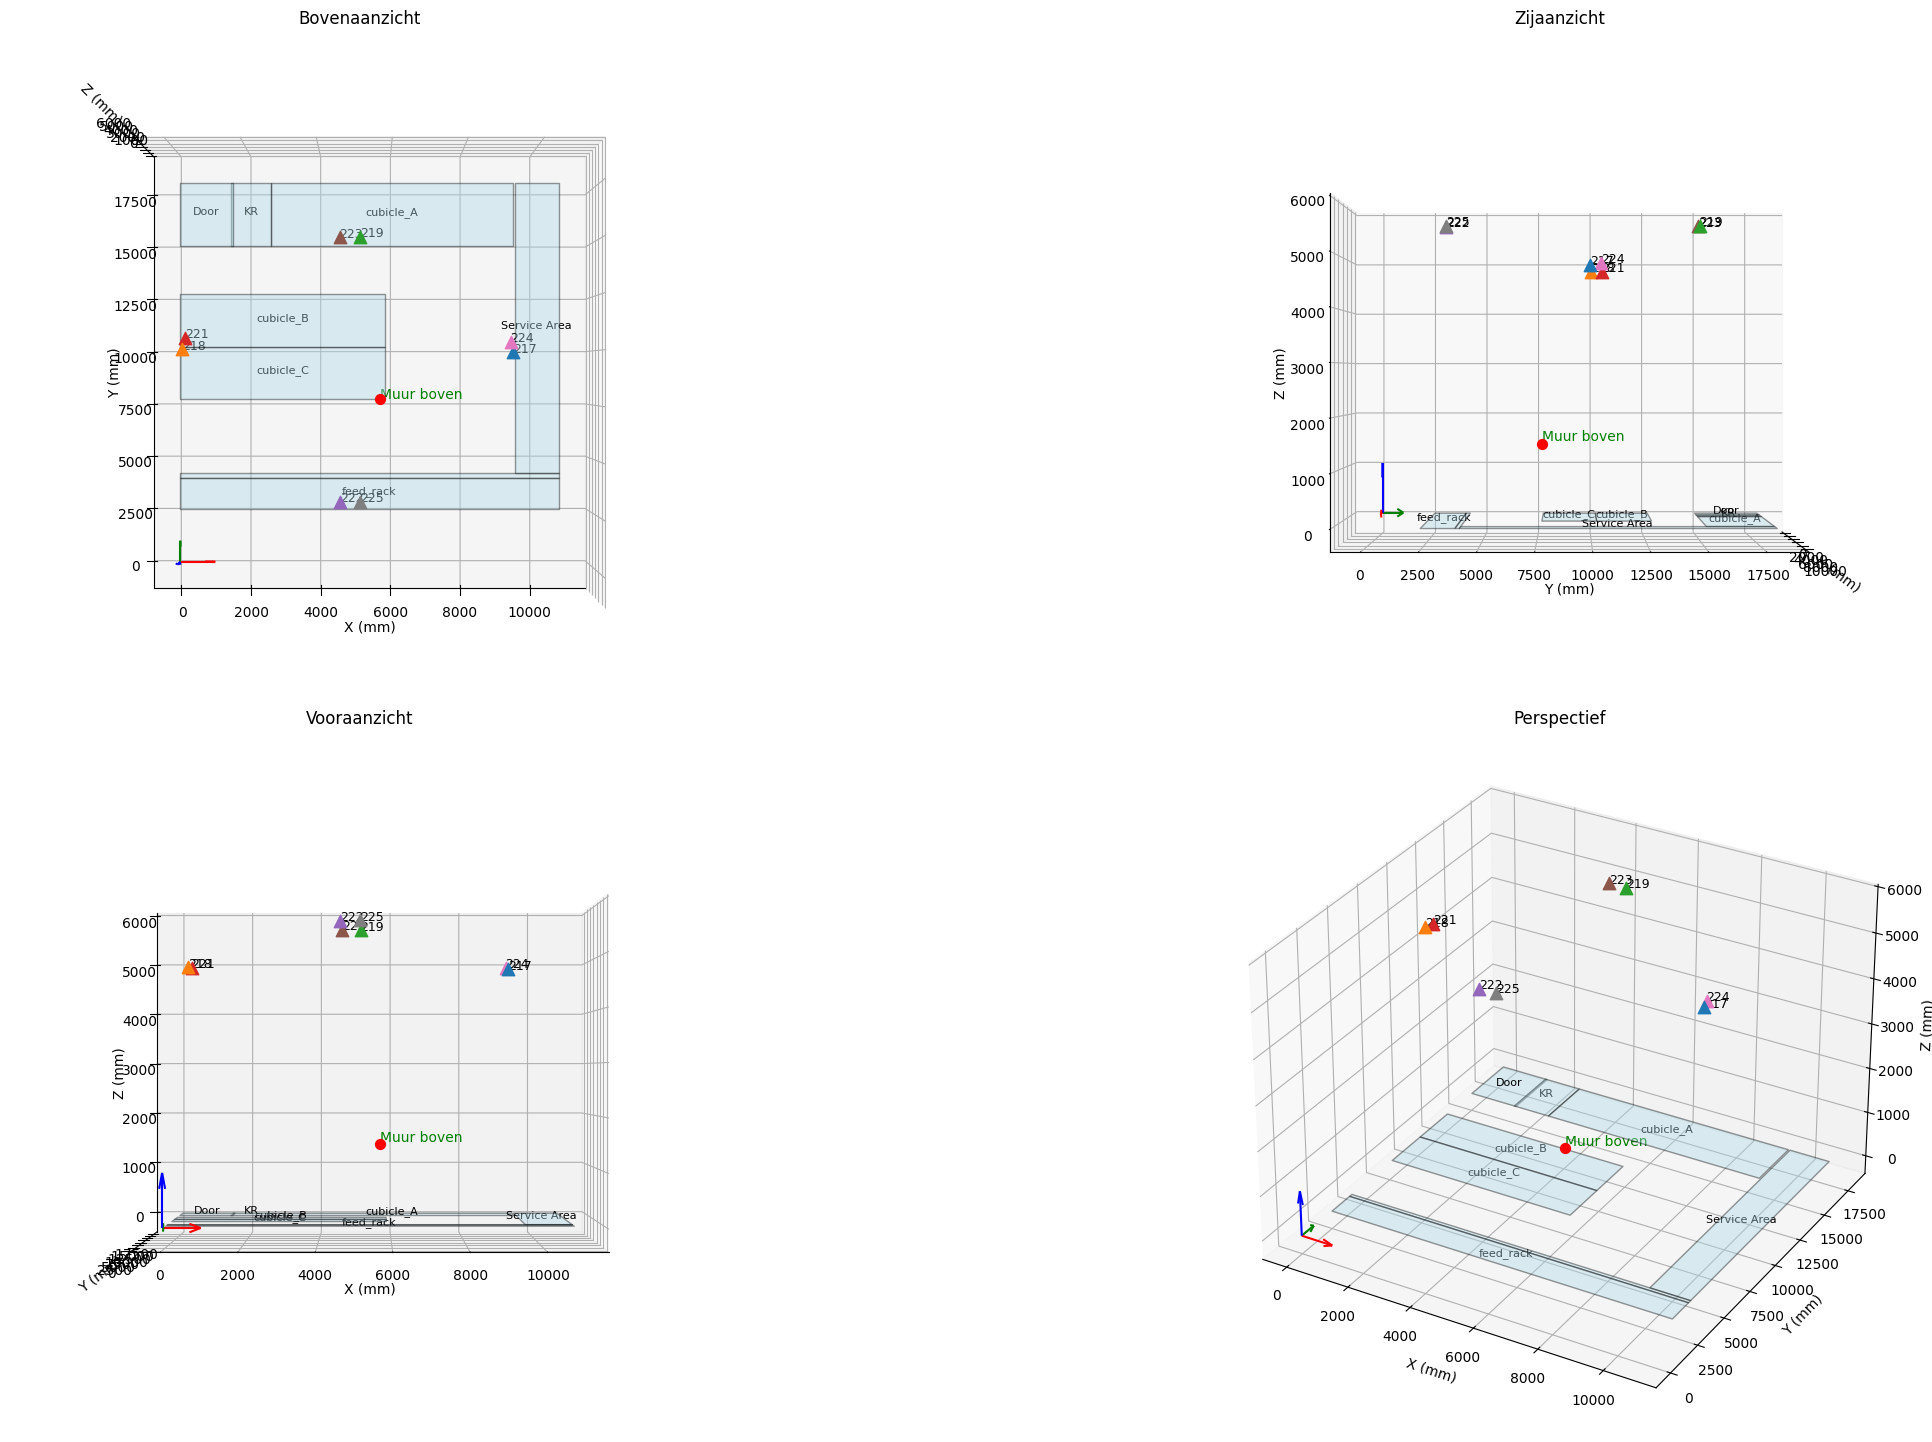

In [90]:
import numpy as np


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


# Camera coordinates in world space
CAM_COORDS = {
    "217": [9238.377, 9900.058, 4804.996],
    "218": [396.4734, 10038.96, 4843.1],
    "219": [5148.143, 14969.01, 5629.784],
    "221": [470.8995, 10538.52, 4838.071],
    "222": [4629.804, 3303.612, 5622.846],
    "223": [4612.065, 14951.8, 5637.818],
    "224": [9167.643, 10376.84, 4835.977],
    "225": [5143.774, 3319.927, 5630.942],
}

def getFromMagicTable(x,y,camera):
    """

    Stuurt de 3D-coördinaten van een pixel in de wereldcoördinaten terug.
    Dit is een snapshot van de tabellen om de demo snel te maken.

    row[0] = x 150cm
    row[1] = y 150cm
    row[2] = x 0cm
    row[3] = y 0cm
    """
    magic_table = {'222-1140-231': (5607.293920138013, 6914.644262489183, 5818.741629167525, 7695.771832739124), '225-1067-211': (5705.8210958570535, 6909.734201632857, 5827.18894524609, 7684.912857096047), '222-1138-229': (5596.06561207702, 6928.562454311799, 5805.084447490738, 7712.700765691559), '225-1065-211': (5694.2472503192175, 6909.449551140021, 5813.1158575846475, 7684.566739522121), '222-1172-229': (5803.707520296461, 6952.683263046729, 6057.642824840503, 7742.03931476721), '225-1075-211': (5752.186661877232, 6910.946900201755, 5883.566635179942, 7686.387424318429), '222-1320-632': (6471.71531815239, 4542.6365296661415, 6870.152047714652, 4810.658566347011), '225-1189-617': (6187.1737225486995, 4530.646202816558, 6412.484272486485, 4792.087490438405)}
    magic_table = {'222-1156-80': (5805.941138399616, 8270.657693808364, 6060.3596124513915, 9345.113985367225), '225-1059-57': (5747.2848090507605, 8245.949242663333, 5877.606282218178, 9309.668548321284)}
    row =  magic_table[f'{camera}-{x}-{y}']

    return row[0], row[1], row[2], row[3]


def get_floor_projection(x, y, camera):
    _, _, x0, y0 = getFromMagicTable(x, y, camera)
    return x0, y0


def triangulate_xyz_from_cameras(kp2, cam2_xyz, kp1, cam1_xyz):
    """
    Berekent het 3D-punt dat het dichtst bij de twee waargenomen lijnen ligt vanuit twee camera's,
    waarbij de inputpunten (kp1, kp2) al op het wereldvlak Z=0 liggen.
    :param kp1: (x, y) wereldcoördinaten op Z=0 vanaf camera 1
    :param cam1_xyz: (x, y, z) positie van camera 1 in wereldcoördinaten
    :param kp2: (x, y) wereldcoördinaten op Z=0 vanaf camera 2
    :param cam2_xyz: (x, y, z) positie van camera 2 in wereldcoördinaten
    :return: (x, y, z) coördinaat in 3D-ruimte
    """
    print("Camera1 Y:", cam1_xyz[1], "  kp1 Y:", kp1[1], "  Verschil:", kp1[1] - cam1_xyz[1])


    p1 = np.array(cam1_xyz)
    d1 = np.array([kp1[0] - cam1_xyz[0], kp1[1] - cam1_xyz[1], 0.0 - cam1_xyz[2]])
    d1 = d1 / np.linalg.norm(d1)

    p2 = np.array(cam2_xyz)
    d2 = np.array([kp2[0] - cam2_xyz[0], kp2[1] - cam2_xyz[1], 0.0 - cam2_xyz[2]])
    d2 = d2 / np.linalg.norm(d2)

    cross_d = np.cross(d1, d2)
    denom = np.linalg.norm(cross_d) ** 2
    if denom == 0:
        return None  # Lijnen zijn (bijna) parallel

    t = np.dot(np.cross((p2 - p1), d2), cross_d) / denom
    s = np.dot(np.cross((p2 - p1), d1), cross_d) / denom

    point1 = p1 + t * d1
    point2 = p2 + s * d2

    midpoint = (point1 + point2) / 2.0
    return  midpoint[0], midpoint[1],midpoint[2]

import numpy as np

points = {}


# '222-1320-632' :pix2coord.convertPixToCoord(1156, 80, 222),
# '225-1189-617' :pix2coord.convertPixToCoord(1059, 57, 225),

# bovenop muur (verwacht een z van rond de 150cm)
x1, y1, x10, y10 = getFromMagicTable(1156, 80, 222)
x3, y4, x30, y40 = getFromMagicTable(1059, 57, 225)
d3 =  triangulate_xyz_from_cameras([x10,y10], CAM_COORDS['222'], [x30,y40],  CAM_COORDS['225'])
points['Muur boven'] = d3

# # vloer bij muur muur
# x1, y1, x10, y10 = getFromMagicTable(1138, 1080-851, 222)
# x3, y2, x30, y40 = getFromMagicTable(1065, 1080-869, 225)
# d3 =  triangulate_xyz_from_cameras([x10,y10], CAM_COORDS['222'], [x30,y40],  CAM_COORDS['225'])
# points['Muur vloer'] = d3
# print(d3)


# # ## deel 4 paal in de lucht
# x1, y1, x10, y10 = getFromMagicTable(1320, 632, 222)
# x3, y2, x30, y40 =  getFromMagicTable(1189, 617, 225)
# d3 =  triangulate_xyz_from_cameras([x10,y10], CAM_COORDS['222'], [x30,y40],  CAM_COORDS['225'])
# points['Paal in lucht'] = d3
# print(d3)




arrow_len = 1000

data = {
'': [[0.0, 4200.0], [10800.0, 4000.0]],
'feed_rack': [[0.0, 4000.0], [10800.0, 2500.0]],
'cubicle_C': [[0.0, 4200+3520+2500], [5850.0, 4200+3520]],
'cubicle_B': [[0.0, 4200+3520+2500+2500], [5850.0, 4200+3520+2500]],
'cubicle_A': [[2600.0, 18000.0], [2600+6*1150, 18000-3000]],
'KR':        [[2600-1150, 18000.0], [2600, 18000-3000]],
'Door':      [[0, 18000.0], [1500, 18000-3000]],
'Service Area': [[10800-1250, 4200], [10800, 18000]],

}


# fig = plt.figure(figsize=(20, 10))
fig = plt.figure(figsize=(24, 14))  # of nog groter bij veel details

views = [
    ("Bovenaanzicht", 90, 270),
    ("Zijaanzicht", 0, 0),      # kijkt langs Y-as → toont X vs Z
    ("Vooraanzicht", 0, 270),   # kijkt langs X-as → toont Y vs Z
    ("Perspectief", 30, 300),



]

for idx, (title, elev, azim) in enumerate(views):
    ax = fig.add_subplot(2, 2, idx + 1, projection='3d')
    ax.set_title(title)

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")
    ax.set_zlabel("Z (mm)")
    ax.view_init(elev=elev, azim=azim)

    # Assen check
    ax.quiver(0, 0, 0, 1000, 0, 0, color='r', label='X-as')  # Rood
    ax.quiver(0, 0, 0, 0, 1000, 0, color='g', label='Y-as')  # Groen
    ax.quiver(0, 0, 0, 0, 0, 1000, color='b', label='Z-as')  # Blauw

    # Vloergebieden tekenen
    for naam, punten in data.items():
        (x1, y1), (x2, y2) = punten

        x_poly = [x1, x2, x2, x1]
        y_poly = [y1, y1, y2, y2]
        z_poly = [0, 0, 0, 0]

        verts = [list(zip(x_poly, y_poly, z_poly))]
        area = Poly3DCollection(verts, alpha=0.4, facecolor='lightblue', edgecolor='k')
        ax.add_collection3d(area)

        # Label in het midden
        cx, cy = np.mean([x1, x2]), np.mean([y1, y2])
        ax.text(cx, cy, 0.1, naam, fontsize=8, ha='center')



    # Camera’s
    for cam_id, pos in CAM_COORDS.items():
        pos = np.array(pos)
        ax.scatter(*pos, marker='^', s=80, label=f"Cam {cam_id}")
        ax.text(*pos, f"{cam_id}", fontsize=9, color='black')
        # ax.quiver(*pos, 0, 0, -arrow_len, color='black', linewidth=1)


    for p in points:
        x,y,z = points[p]
        ax.scatter( x,y, z, c='red', s=50)
        ax.text( x, y,z + 50, f"{p} ", color='green')


plt.tight_layout()  # deze mag weg als je subplots_adjust gebruikt
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
plt.show()
